<a href="https://colab.research.google.com/github/YifanSong348/STATS303/blob/main/HW/STATS303_Week_2_EM_GMM_%2B_K_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Week 2 - Homework - Yifan Song (ys251)
###Problem 6 Programming: EM-GMM vs K-means 

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
# plt.style.use('seaborn')
from matplotlib import style
style.use('ggplot')

##**1.** In $R^2$, from a Gaussian mixture model (GMM) with `K = 2` components, generate `100` points.

In [25]:

# # cluster 1
# num1, mu1, var1 = 50, [0, 8], [4, 4]
# X1 = np.random.multivariate_normal(mu1, np.diag(var1), num1)

# # cluster 2
# num2, mu2, var2 = 50, [2, 4], [3,3]
# X2 = np.random.multivariate_normal(mu2, np.diag(var2), num2)

# generate data points
# cluster 1
num1, mu1, var1 = 50, [0, 8], np.array([[4,0],[0,4]])
X1 = np.random.multivariate_normal(mu1, var1, num1)

# cluster 2
num2, mu2, var2 = 50, [2, 4], np.array([[3,1],[1,3]])
X2 = np.random.multivariate_normal(mu2, var2, num2)

In [26]:
# add noise
noise = np.random.normal(0, 0.25**2, [50, 2])
X1_noisy = X1 + noise
X2_noisy = X2 + noise
X_noisy = np.vstack((X1_noisy, X2_noisy))

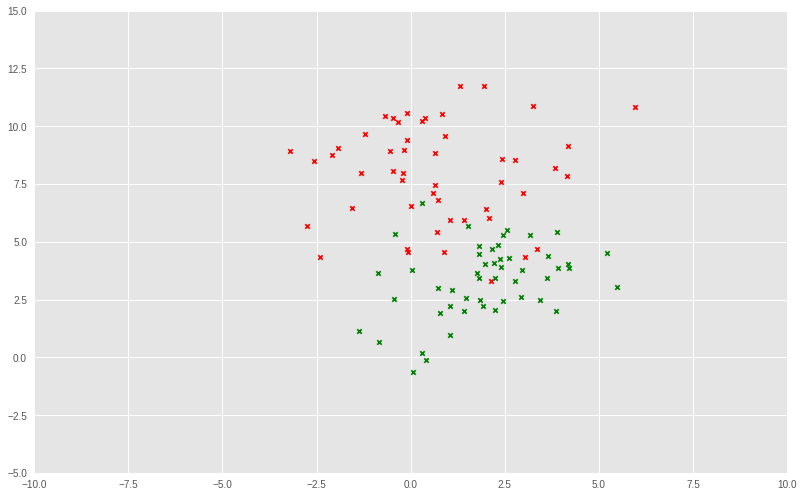

In [27]:
# plot the data points
plt.figure(figsize=(13.5, 8.5))
plt.axis([-10, 10, -5, 15])
plt.scatter(X1_noisy[:, 0], X1_noisy[:, 1], marker="x", color= 'r', s=20)
plt.scatter(X2_noisy[:, 0], X2_noisy[:, 1], marker="x", color= 'g', s=20)
# plt.scatter(X3[:, 0], X3[:, 1], s=5)
plt.show()

##**2.** Perform `K-means` with `K = 2` to the data. Show your results in color.

In [34]:
class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self,data):

        self.centroids = {}

        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(self.max_iter):
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []

            for featureset in data:
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)

            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification],axis=0)

            optimized = True

            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
                    print(np.sum((current_centroid-original_centroid)/original_centroid*100.0))
                    optimized = False

            if optimized:
                break

    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

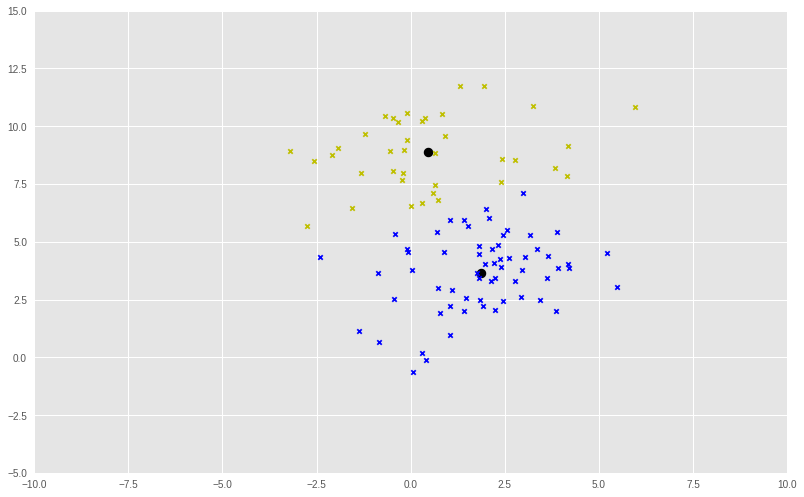

In [58]:
model = K_Means()
model.fit(X_noisy)

for centroid in model.centroids:
    plt.scatter(model.centroids[centroid][0], model.centroids[centroid][1],
                marker="o", color="k", s=20, linewidths=5)

for classification in model.classifications:
    colors = ['b', 'y']
    color = colors[classification]
    for featureset in model.classifications[classification]:
        plt.scatter(featureset[0], featureset[1], marker="x", color=color, s=20, linewidths=5)
plt.axis([-10, 10, -5, 15])  
fig = plt.gcf()
fig.set_size_inches(13.5, 8.5)      
plt.show()

##**3.** Perform `EM` with `K = 2` to the data. Show your results in color.

In [36]:
# initialize the variables
n_clusters = 2  # number of clusters
n_points = len(X_noisy)  # number of points
Mu = [[-1, 8], [2, 4]]  # Mean
Var = [[1, 1], [1, 1]]  # Variance
# Pi = [1 / n_clusters] * 2
W = np.ones((n_points, n_clusters)) / n_clusters  # the probability that the sample is in each cluster
Pi = W.sum(axis=0) / W.sum()  # the weight of each cluster

Expectation step

In [37]:
# update W
def update_W(X, Mu, Var, Pi):
    n_points, n_clusters = len(X), len(Pi)
    pdfs = np.zeros(((n_points, n_clusters)))
    for i in range(n_clusters):
        pdfs[:, i] = Pi[i] * multivariate_normal.pdf(X, Mu[i], np.diag(Var[i]))
    W = pdfs / pdfs.sum(axis=1).reshape(-1, 1)
    return W

# update Pi
def update_Pi(W):
    Pi = W.sum(axis=0) / W.sum()
    return Pi

In [42]:
# calculate the log-likelihood
def logLH(X, Pi, Mu, Var):
    n_points, n_clusters = len(X), len(Pi)
    pdfs = np.zeros(((n_points, n_clusters)))
    for i in range(n_clusters):
        pdfs[:, i] = Pi[i] * multivariate_normal.pdf(X, Mu[i], np.diag(Var[i]))
    return np.mean(np.log(pdfs.sum(axis=1)))

# plot the cluster figure
def plot_clusters(X, Mu, Var, Mu_true=None, Var_true=None):
    colors = ['r', 'g']
    n_clusters = len(Mu)
    plt.figure(figsize=(10, 8))
    plt.axis([-10, 15, -5, 15])
    # plt.scatter(X_noisy[:, 0], X_noisy[:, 1], s=20)
    plt.scatter(X1_noisy[:, 0], X1_noisy[:, 1], marker="x", color= 'r', s=20)
    plt.scatter(X2_noisy[:, 0], X2_noisy[:, 1], marker="x", color= 'g', s=20)
    ax = plt.gca()
    for i in range(n_clusters):
        plot_args = {'fc': 'None', 'lw': 2, 'edgecolor': colors[i], 'ls': ':'}
        ellipse = Ellipse(Mu[i], 2 * Var[i][0], 2 * Var[i][1], **plot_args)
        ax.add_patch(ellipse)
    # if (Mu_true is not None) & (Var_true is not None):
    #     for i in range(n_clusters):
    #         plot_args = {'fc': 'None', 'lw': 2, 'edgecolor': colors[i], 'alpha': 0.5}
    #         ellipse = Ellipse(Mu_true[i], 2 * Var_true[i][0], 2 * Var_true[i][1], **plot_args)
    #         ax.add_patch(ellipse)         
    plt.show()

Maximization step

In [39]:
# update Mu
def update_Mu(X, W):
    n_clusters = W.shape[1]
    Mu = np.zeros((n_clusters, 2))
    for i in range(n_clusters):
        Mu[i] = np.average(X, axis=0, weights=W[:, i])
    return Mu

# update the variance
def update_Var(X, Mu, W):
    n_clusters = W.shape[1]
    Var = np.zeros((n_clusters, 2))
    for i in range(n_clusters):
        Var[i] = np.average((X - Mu[i]) ** 2, axis=0, weights=W[:, i])
    return Var

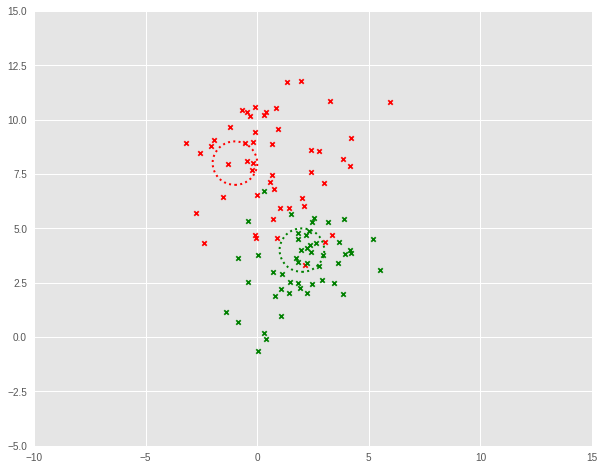

log-likehood:-5.783


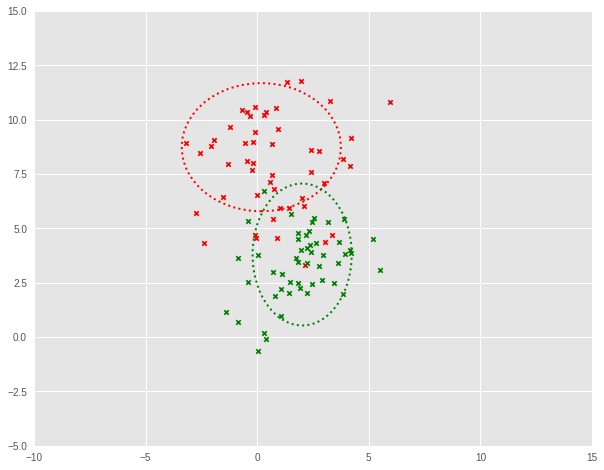

log-likehood:-4.446


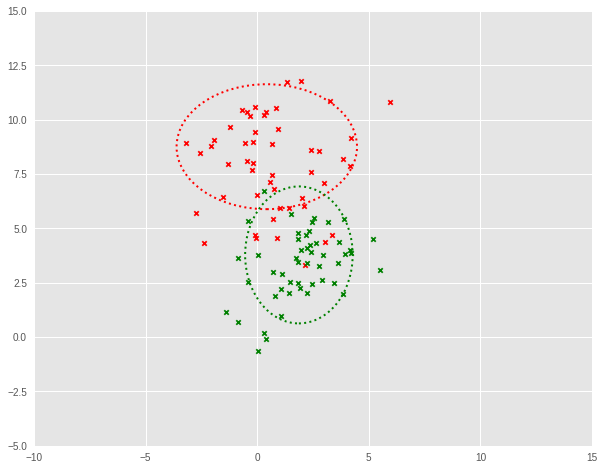

log-likehood:-4.434


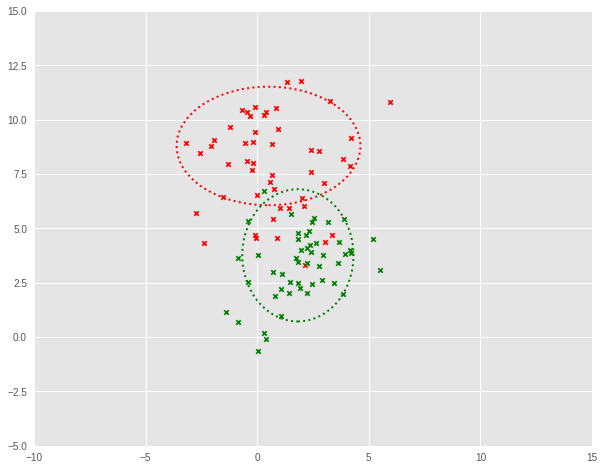

log-likehood:-4.432


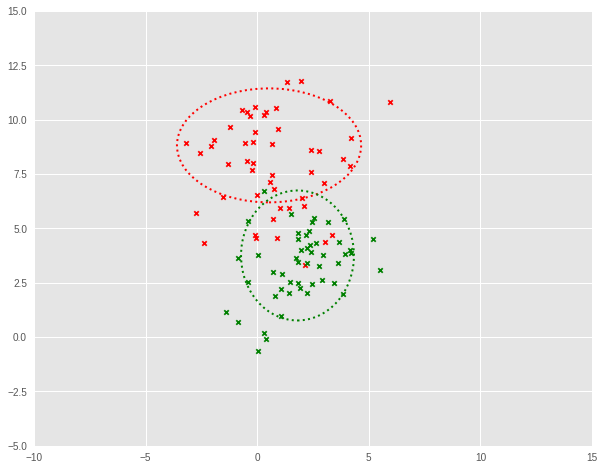

log-likehood:-4.432


In [40]:
# find the classification through iteration (iteration number = 5)
loglh = []
for i in range(5):
    plot_clusters(X_noisy, Mu, Var, [mu1, mu2], [var1, var2])
    loglh.append(logLH(X_noisy, Pi, Mu, Var))
    W = update_W(X_noisy, Mu, Var, Pi)
    Pi = update_Pi(W)
    Mu = update_Mu(X_noisy, W)
    print('log-likehood:%.3f'%loglh[-1])
    Var = update_Var(X_noisy, Mu, W)